Text Classification on Job Postings

In [1]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4d2581a5e6b0ff9b7914cc5770566060fa3f8fb6789f0480752c7e8b16cdde9f
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=576c9c8b4e1dcc8e1204998440330c5180e815b986803f448ccac29f281f9a95
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [2]:
import pandas as pd
import nltk
import warnings
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import gensim.corpora as corpora
from gensim.models import HdpModel
import time
time.clock = time.time
from gensim.models import CoherenceModel
from operator import itemgetter
import pyLDAvis.gensim_models
from gensim.models import LdaModel
import pickle 
import pyLDAvis
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import re
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/AUD Project/'
df = pd.read_csv(path + "Job listings - Category food.csv")

#Glimpse of the raw scraped data
df.head()

,Link,Posting Title,Location,Category,Posting Text
0,https://stlouis.craigslist.org/fbh/d/saint-lou...,Prep and Event Cooks,stlouis,fbh,QR Code Link to This Post Need of experience...
1,https://chicago.craigslist.org/chc/fbh/d/india...,"DIRECTOR, DINING SERVICES - K12 - Pike Townshi...",chicago,fbh,QR Code Link to This Post Salary: Chartwel...
2,https://lansing.craigslist.org/fbh/d/bath-shop...,Shop and Deliver - No Experience Required,lansing,fbh,QR Code Link to This Post Shop and delive...
3,https://bn.craigslist.org/fbh/d/south-bend-exe...,EXECUTIVE CHEF - K12 - Career Academy - South ...,bn,fbh,QR Code Link to This Post Salary: Chartwel...
4,https://stlouis.craigslist.org/fbh/d/chesterfi...,RESIDENT DISTRICT MANAGER - K12 - Parkway Scho...,stlouis,fbh,QR Code Link to This Post Salary: Chartwel...


In [5]:
#Checking shape of the dataset - before removing duplicated descriptions
df.shape

(1464, 5)

In [6]:
#Removing repeating job descriptions 
df = df.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Posting Text'], keep='first')

#Checking shape of the dataset - after removing duplicated descriptions
df.shape

(1459, 5)

In [7]:
#Cleaning the data

#tokenizing 

df['tokenized description'] = [nltk.word_tokenize(x) for x in df['Posting Text']]

#removing punctuations so words such as "jobs" and "jobs." are not treated separately after tokenizing

review_collection=[]
for l in df['tokenized description']:
    single_review=[]
    for word in l:
        res = re.sub(r'[^\w\s]', '', word)
        single_review.append(res)
    review_collection.append(single_review)
    
df['cleaned description'] = review_collection

#removing all the stop-words and the punctuations
#note : we have added a few highly frequent words to the stopwords list after looking at a couple of reviews

stopwords_list = stopwords.words('english')

words_to_add = ['qr','code','link','to','this','post','click','here','http','https']
stopwords_list = stopwords_list + words_to_add

stop_words_removed_description=[]
for l in df['cleaned description']:
    stop_words_removed=[] 
    stop_words_removed=[word for word in l if word.lower() not in stopwords_list if word.isalpha()]
    stop_words_removed_description.append(stop_words_removed)

df['stop_words_removed description'] = stop_words_removed_description

#removing single letters between reviews since they do not give us any information

single_letter_removed_description=[]
for l in df['stop_words_removed description']:
    single_letter_removed=[] 
    single_letter_removed=[word for word in l if len(word)!=1]
    single_letter_removed_description.append(single_letter_removed)
    
df['single_letter_removed_description'] = single_letter_removed_description

#lemmatizing the words in each review

lemmatizer = WordNetLemmatizer()
lemmatized_description=[]
for l in df['single_letter_removed_description']:
    lemmatized_words=[]
    lemmatized_words=[lemmatizer.lemmatize(word.lower()) if word.isalpha() else word.lower() for word in l ]
    lemmatized_description.append(lemmatized_words)

df['lemmatized description'] = lemmatized_description

df['final cleaned posting text'] = [' '.join(word) for word in df['lemmatized description']]
df.head()

,Link,Posting Title,Location,Category,Posting Text,tokenized description,cleaned description,stop_words_removed description,single_letter_removed_description,lemmatized description,final cleaned posting text
0,https://stlouis.craigslist.org/fbh/d/saint-lou...,prep and event cooks,stlouis,fbh,qr code link to this post need of experience...,"[qr, code, link, to, this, post, need, of, exp...","[qr, code, link, to, this, post, need, of, exp...","[need, experienced, prep, cooks, need, cooks, ...","[need, experienced, prep, cooks, need, cooks, ...","[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...
1,https://chicago.craigslist.org/chc/fbh/d/india...,"director, dining services - k12 - pike townshi...",chicago,fbh,qr code link to this post salary: chartwel...,"[qr, code, link, to, this, post, salary, :, ch...","[qr, code, link, to, this, post, salary, , cha...","[salary, chartwells, goal, make, sure, student...","[salary, chartwells, goal, make, sure, student...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...
2,https://lansing.craigslist.org/fbh/d/bath-shop...,shop and deliver - no experience required,lansing,fbh,qr code link to this post shop and delive...,"[qr, code, link, to, this, post, shop, and, de...","[qr, code, link, to, this, post, shop, and, de...","[shop, deliver, flexible, schedule, earn, addi...","[shop, deliver, flexible, schedule, earn, addi...","[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...
3,https://bn.craigslist.org/fbh/d/south-bend-exe...,executive chef - k12 - career academy - south ...,bn,fbh,qr code link to this post salary: chartwel...,"[qr, code, link, to, this, post, salary, :, ch...","[qr, code, link, to, this, post, salary, , cha...","[salary, chartwells, goal, make, sure, student...","[salary, chartwells, goal, make, sure, student...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...
4,https://stlouis.craigslist.org/fbh/d/chesterfi...,resident district manager - k12 - parkway scho...,stlouis,fbh,qr code link to this post salary: chartwel...,"[qr, code, link, to, this, post, salary, :, ch...","[qr, code, link, to, this, post, salary, , cha...","[salary, chartwells, goal, make, sure, student...","[salary, chartwells, goal, make, sure, student...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...


In [8]:
#deleting unnecessary and intermediate columns and keeping the final cleaned posting text
df.drop(['Link', 'Location', 'Category', 'Posting Text', 'tokenized description', 'cleaned description', 'stop_words_removed description','single_letter_removed_description'], axis=1, inplace=True)
df.head()

,Posting Title,lemmatized description,final cleaned posting text
0,prep and event cooks,"[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...
1,"director, dining services - k12 - pike townshi...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...
2,shop and deliver - no experience required,"[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...
3,executive chef - k12 - career academy - south ...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...
4,resident district manager - k12 - parkway scho...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...


K MEANS

In [9]:
# Trying K means to get clusters for extracting titles from the documents

#Creating tf-idf vector

food_data = list(df['final cleaned posting text'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
Tfidf_food = vectorizer.fit_transform(food_data)
print(vectorizer.vocabulary_)

{'need': 10463, 'experienced': 5537, 'prep': 12256, 'cook': 3154, 'afternoon': 355, 'evening': 5169, 'event': 5180, 'need experienced': 10475, 'experienced prep': 5550, 'prep cook': 12258, 'need cook': 10469, 'afternoon evening': 356, 'salary': 14075, 'chartwells': 2215, 'goal': 6631, 'make': 9462, 'sure': 15818, 'student': 15640, 'leave': 8802, 'cafeteria': 1866, 'happier': 7097, 'healthier': 7155, 'came': 1921, 'serving': 14626, 'food': 6019, 'kid': 8471, 'love': 9295, 'eat': 4512, 'creating': 3399, 'custom': 3555, 'dining': 4089, 'program': 12623, 'associate': 912, 'school': 14269, 'ranging': 13038, 'large': 8659, 'public': 12849, 'institution': 8056, 'small': 15009, 'charter': 2213, 'private': 12449, 'built': 1760, 'decade': 3770, 'education': 4530, 'operational': 10993, 'experience': 5406, 'driven': 4387, 'top': 16541, 'culinary': 3489, 'nutrition': 10712, 'wellness': 17494, 'sustainability': 15842, 'talent': 15940, 'information': 7969, 'visit': 17193, 'summarythe': 15728, 'direct

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


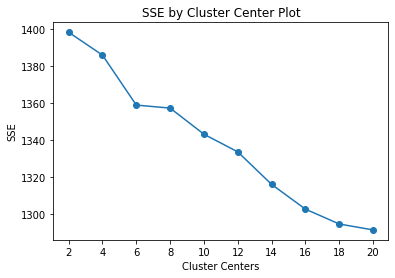

In [10]:
#Getting optimal number of clusters :

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=100).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(Tfidf_food, 20)

In [11]:
#10 seems to be a good choice for the number of clusters by elbow method. We can check with 10 clusters.

Kmeans_model = MiniBatchKMeans(n_clusters=10, init_size=1024, batch_size=2048, random_state=100).fit(Tfidf_food) 
Kmeans_model.cluster_centers_
Kmeans_model.fit_transform(Tfidf_food)
Kmeans_model_clusters = Kmeans_model.labels_.tolist()
print(Kmeans_model_clusters)

[1, 4, 5, 4, 4, 3, 3, 5, 5, 6, 9, 4, 4, 6, 4, 5, 5, 6, 6, 5, 1, 3, 6, 9, 0, 0, 0, 9, 4, 6, 6, 4, 4, 6, 9, 4, 4, 4, 4, 5, 6, 5, 6, 0, 0, 5, 3, 3, 2, 2, 8, 6, 8, 1, 1, 6, 9, 6, 6, 5, 6, 6, 5, 5, 9, 3, 3, 6, 3, 6, 5, 3, 9, 9, 9, 2, 8, 5, 5, 4, 2, 9, 9, 1, 6, 1, 6, 6, 9, 6, 6, 6, 3, 1, 3, 6, 6, 2, 6, 0, 2, 0, 6, 6, 6, 5, 6, 1, 6, 6, 6, 1, 3, 0, 9, 5, 1, 2, 1, 1, 6, 1, 9, 3, 1, 3, 3, 9, 9, 2, 0, 6, 9, 9, 9, 0, 6, 6, 3, 8, 3, 6, 9, 9, 9, 6, 1, 2, 2, 5, 5, 9, 1, 6, 6, 5, 1, 5, 9, 5, 3, 2, 2, 2, 2, 5, 1, 6, 5, 6, 1, 6, 3, 5, 6, 3, 2, 5, 6, 6, 6, 3, 2, 3, 9, 9, 0, 8, 8, 8, 0, 2, 6, 1, 5, 5, 6, 2, 5, 5, 4, 5, 9, 6, 2, 9, 9, 3, 2, 6, 5, 1, 5, 5, 5, 6, 6, 6, 6, 9, 1, 0, 6, 1, 2, 1, 1, 3, 2, 6, 6, 6, 6, 1, 5, 5, 8, 6, 9, 6, 9, 6, 6, 9, 5, 1, 2, 2, 2, 5, 0, 6, 6, 5, 6, 9, 5, 5, 6, 6, 0, 0, 6, 1, 2, 6, 5, 6, 6, 6, 8, 8, 6, 2, 1, 6, 6, 2, 2, 3, 5, 3, 6, 6, 9, 6, 0, 0, 5, 1, 2, 6, 9, 9, 6, 6, 9, 3, 5, 1, 5, 3, 6, 2, 5, 5, 6, 6, 0, 3, 2, 2, 2, 2, 4, 2, 6, 6, 1, 9, 6, 0, 6, 2, 2, 2, 2, 5, 2, 5, 1, 6, 2, 

In [12]:
order_centroids = Kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [13]:
#len(order_centroids) = 10
cluster_terms_list = []
for i in range(len(order_centroids)):
  print('centroid : ', i)
  terms_list = []
  for index in order_centroids[i, :20]:
     terms_list.append(terms[index])
  cluster_terms_list.append(terms_list)
  print(terms_list)

centroid :  0
['saturday', 'sunday', 'friday saturday', 'friday', 'sushi', 'monday', 'looking', 'must', 'steakhouse', 'saturday sunday', 'call', 'please', 'delivery', 'experience', 'time', 'monday saturday', 'delivery driver', 'sunday monday', 'tuesday', 'night']
centroid :  1
['cook', 'line', 'line cook', 'kitchen', 'food', 'experience', 'cooking', 'prep', 'must', 'work', 'looking', 'restaurant', 'experienced', 'team', 'chef', 'apply', 'position', 'please', 'person', 'experienced line']
centroid :  2
['guest', 'food', 'ability', 'service', 'work', 'able', 'restaurant', 'must', 'duty', 'team', 'customer', 'procedure', 'move', 'including', 'order', 'follow', 'effectively', 'lift', 'skill', 'area']
centroid :  3
['event', 'experience', 'manager', 'team', 'restaurant', 'time', 'work', 'management', 'paid', 'benefit', 'chef', 'food', 'hour', 'insurance', 'kitchen', 'working', 'service', 'position', 'employee', 'full']
centroid :  4
['applicant', 'compass', 'legendary', 'status', 'gender', 

In [14]:
#Assigning Kmeans clusters to each document:

df['cluster'] = Kmeans_model_clusters
df.head()

,Posting Title,lemmatized description,final cleaned posting text,cluster
0,prep and event cooks,"[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...,1
1,"director, dining services - k12 - pike townshi...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4
2,shop and deliver - no experience required,"[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...,5
3,executive chef - k12 - career academy - south ...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4
4,resident district manager - k12 - parkway scho...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4


In [15]:
#K means cluster descriptions:

#Topic 0: Part-time for Specific Days
#Topic 1: Chef/Kitchen Staff
#Topic 2: Server
#Topic 3: Manager(event/restaurant)
#Topic 4: Outside city/Highway restaurant job
#Topic 5: Food delivery
#Topic 6: Cook/bartender
#Topic 7: Part-time server
#Topic 8: Mexican restaurant
#Topic 9: Employee

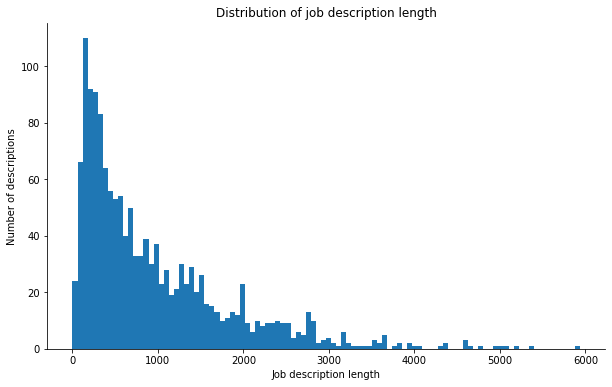

In [16]:
#Trying out other topic modeling approaches:

#3 topic modelling approaches are available:

#1. LDA : Latent Dirichlet Allocation
#2. NMF : Non-Negative Matrix Factorization
#3. HDP : Hierarchical Dirichlet process 

#HDP is an extension of LDA, designed to address the case where the number of mixture components (the number of "topics" in document-modeling terms) is not known a priori. So that's the reason why there's a difference.

#Source: https://datascience.stackexchange.com/questions/128/latent-dirichlet-allocation-vs-hierarchical-dirichlet-process#:~:text=Latent%20Dirichlet%20Allocation%20(LDA)%20and,%2C%20and%20HDP%20doesn't.

#Ideally, NMF is used for shorter texts and tweets. 

#Determining how long the job descriptions are in general:

plt.figure(figsize=(10,6))

doc_lens = [len(d) for d in df['final cleaned posting text']]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of job description length')
plt.ylabel('Number of descriptions')
plt.xlabel('Job description length')
sns.despine();

#We observe that most job descriptions are pretty long. Hence we discard the NMF method. 
#Source: https://www.researchgate.net/publication/327089757_Experimental_explorations_on_short_text_topic_mining_between_LDA_and_NMF_based_Schemes

In [17]:
#Transforming data to prepare for the input to lda model

lemmatized_description_list_of_list = list(df['lemmatized description'])

#Dictionary
id2word = corpora.Dictionary(lemmatized_description_list_of_list)
#Corpus
texts = lemmatized_description
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1)]]


LDA

In [18]:
#Building a baseline LDA model : starting with 5 topics for now

lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=5, 
                     random_state=100,
                     chunksize=100,
                     passes=10)

In [19]:
#Top 10 words for each topic

for idx, topic in lda_model.print_topics():
   print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"food" + 0.008*"service" + 0.008*"work" + 0.008*"experience" + 0.007*"position" + 0.007*"employee" + 0.007*"team" + 0.007*"manager" + 0.006*"management" + 0.006*"company"
Topic: 1 
Words: 0.046*"de" + 0.020*"en" + 0.016*"para" + 0.015*"un" + 0.015*"la" + 0.010*"con" + 0.008*"los" + 0.008*"pm" + 0.007*"debe" + 0.007*"el"
Topic: 2 
Words: 0.016*"guest" + 0.011*"restaurant" + 0.011*"including" + 0.010*"move" + 0.009*"team" + 0.008*"service" + 0.008*"effectively" + 0.008*"follow" + 0.008*"work" + 0.007*"career"
Topic: 3 
Words: 0.018*"food" + 0.015*"team" + 0.012*"restaurant" + 0.012*"guest" + 0.012*"work" + 0.012*"service" + 0.011*"experience" + 0.009*"kitchen" + 0.008*"able" + 0.007*"ability"
Topic: 4 
Words: 0.014*"time" + 0.013*"work" + 0.013*"looking" + 0.011*"hour" + 0.010*"experience" + 0.009*"pay" + 0.009*"apply" + 0.009*"shift" + 0.008*"team" + 0.008*"great"


In [20]:
#Computing coherence score: Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_description_list_of_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.481743744532654


In [21]:
#Running a Grid search to get the best parameters that yield a high coherence score

num_topics=[6,7,8,9,10,11,12]

coherence_scores=[]
parameters=[]
for n in num_topics:
    parameters.append(str(n))
    lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=n, 
                     random_state=100,
                     chunksize=100,
                     passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_description_list_of_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [22]:
grid_search_df = pd.DataFrame(columns=['topics', 'coherence score'])
grid_search_df['topics'] = parameters
grid_search_df['coherence score'] = coherence_scores

In [23]:
grid_search_df

,topics,coherence score
0,6,0.489309
1,7,0.494477
2,8,0.489071
3,9,0.489092
4,10,0.505953
5,11,0.486804
6,12,0.528046


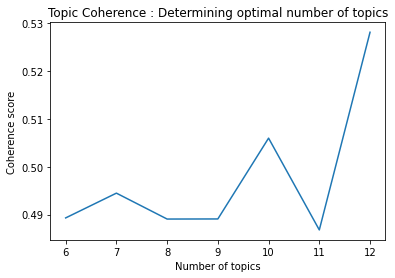

In [24]:
#Plotting number of topics vs. coherence score

plt.plot(grid_search_df['topics'], grid_search_df['coherence score'])
plt.title('Topic Coherence : Determining optimal number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

#We see that after 10, the coherence score takes a huge dip. As of now, we can go with 10 topics.

In [25]:
#Running the final lda model with 10 topics

lda_model_10topics = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=10, 
                     random_state=100,
                     chunksize=100,
                     passes=10)

In [26]:
ldatopics = lda_model_10topics.show_topics(formatted=False)

In [27]:
#Top 10 words for each topic

for idx, topic in lda_model_10topics.print_topics():
   print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"manager" + 0.012*"management" + 0.011*"work" + 0.011*"experience" + 0.010*"team" + 0.009*"skill" + 0.008*"employee" + 0.008*"staff" + 0.007*"must" + 0.007*"required"
Topic: 1 
Words: 0.039*"guest" + 0.023*"team" + 0.021*"member" + 0.019*"service" + 0.013*"customer" + 0.010*"environment" + 0.008*"server" + 0.007*"provide" + 0.007*"friendly" + 0.006*"great"
Topic: 2 
Words: 0.019*"guest" + 0.014*"move" + 0.014*"restaurant" + 0.013*"including" + 0.011*"effectively" + 0.011*"follow" + 0.011*"team" + 0.011*"pound" + 0.010*"procedure" + 0.010*"work"
Topic: 3 
Words: 0.034*"food" + 0.018*"work" + 0.016*"kitchen" + 0.013*"ability" + 0.011*"service" + 0.010*"able" + 0.010*"cook" + 0.009*"standard" + 0.009*"must" + 0.009*"clean"
Topic: 4 
Words: 0.018*"looking" + 0.018*"time" + 0.016*"work" + 0.015*"experience" + 0.014*"hour" + 0.011*"shift" + 0.011*"team" + 0.010*"great" + 0.010*"please" + 0.010*"day"
Topic: 5 
Words: 0.024*"delivery" + 0.023*"driver" + 0.013*"sale" + 0.

In [28]:
#Determining topic themes looking at the 10 words for each topic:

#Topic 0: Manager
#Topic 1: Server
#Topic 2: Restaurant Host
#Topic 3: Cleaning staff
#Topic 4: Server in shifts
#Topic 5: Delivery
#Topic 6: Mexican
#Topic 7: Chef
#Topic 8: Associate position at catering
#Topic 9: Employee/Kitchen Staff

In [29]:
#Visualising the topics

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_10topics, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.014531 -0.045819       1        1  24.739974
3      0.132695 -0.152524       2        1  16.265953
0      0.118237 -0.021834       3        1  15.508943
1      0.102975 -0.035066       4        1   8.860000
2      0.150567 -0.095665       5        1   8.315487
8      0.006180  0.206883       6        1   6.402555
9     -0.052491  0.221546       7        1   6.247512
7     -0.000541  0.048197       8        1   4.975819
6     -0.332739 -0.177687       9        1   4.580408
5     -0.139415  0.051970      10        1   4.103349, topic_info=            Term         Freq        Total Category  logprob  loglift
897        guest  1057.000000  1057.000000  Default  30.0000  30.0000
1355          de   481.000000   481.000000  Default  29.0000  29.0000
829   restaurant  1295.000000  1295.000000  Default  28.0000  28.0000
128         food  1542.000000  1542.000000  Default  27.0000  27.0000
573     employee   757.000000   757.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
26         apply    43.628344   899.426339  Topic10  -5.1359   0.1673
260      service    40.827373  1159.595935  Topic10  -5.2023  -0.1531
188         must    39.152395   913.828235  Topic10  -5.2442   0.0432
692          pay    35.232798   578.910348  Topic10  -5.3496   0.3942
304         work    32.328337  1922.061818  Topic10  -5.4357  -0.8918

[667 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8         2  0.528263  ability
8         3  0.238071  ability
8         4  0.022539  ability
8         5  0.188766  ability
8         6  0.021131  ability
...     ...       ...      ...
306       6  0.053094     year
306       7  0.056886     year
306       8  0.060678     year
306       9  0.034132     year
306      10  0.034132     year

[1297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3, 9, 10, 8, 7, 6])

In [30]:
#Finding the dominant topic for each job description by topic number that has the highest percentage contribution in that document.

dominant_topic=[]
index=0
for i in lda_model_10topics[corpus]:
  #print('Job description :', index, max(i,key=itemgetter(1))[0])
  dominant_topic.append(max(i,key=itemgetter(1))[0])
  index+=1

In [31]:
#Creating a new column in the dataset for the dominant topic

df['dominant topic'] = dominant_topic

In [32]:
df.head()

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic
0,prep and event cooks,"[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...,1,4
1,"director, dining services - k12 - pike townshi...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8
2,shop and deliver - no experience required,"[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...,5,5
3,executive chef - k12 - career academy - south ...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8
4,resident district manager - k12 - parkway scho...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8


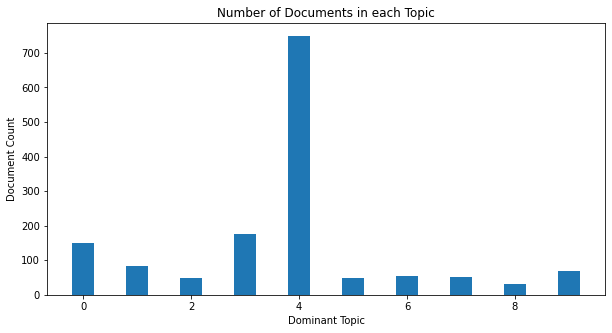

In [33]:
#bar chart
df_bar = pd.DataFrame(df['dominant topic'].value_counts())
df_bar = df_bar.reset_index()
df_bar.columns = ['Dominant Topic','Document Count']
fig = plt.figure(figsize = (10,5))
plt.bar(df_bar['Dominant Topic'], df_bar['Document Count'],
        width = 0.4)
plt.xlabel("Dominant Topic")
plt.ylabel("Document Count")
plt.title("Number of Documents in each Topic")
plt.show()

HDP

In [34]:
#Using HDP method to model topics in the data

hdpmodel = HdpModel(corpus=corpus, id2word=id2word, random_state=23)
hdptopics = hdpmodel.show_topics(formatted=False)

In [35]:
hdptopics[0]

(0,
 [('work', 0.009003560214961234),
  ('team', 0.00804574513603789),
  ('food', 0.007874144959656708),
  ('restaurant', 0.0070673025966501895),
  ('experience', 0.006935501682327386),
  ('time', 0.006367805371037997),
  ('service', 0.0059615229052077685),
  ('looking', 0.005297378077480246),
  ('apply', 0.004876147327998187),
  ('employee', 0.0046663089591346745),
  ('guest', 0.00444813213810133),
  ('must', 0.004419933673612831),
  ('cook', 0.004015705943857283),
  ('hour', 0.003937377150287101),
  ('position', 0.003827484480729153),
  ('opportunity', 0.003762826849573286),
  ('shift', 0.003539272696170741),
  ('working', 0.003442873406543738),
  ('company', 0.003426405780651777),
  ('job', 0.0033820891872483384)])

In [36]:
#Comparing LDA and HDP for Coherence Score

hdptopics_cv = [[word for word, prob in topic] for topicid, topic in hdptopics]
#len(hdptopics_cv) 20
ldatopics_cv = [[word for word, prob in topic] for topicid, topic in ldatopics]
#len(ldatopics_cv) 10

In [37]:
lda_coherence = CoherenceModel(topics=ldatopics_cv, texts=lemmatized_description, dictionary=id2word, coherence='c_v').get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics_cv, texts=lemmatized_description, dictionary=id2word,  coherence='c_v').get_coherence()

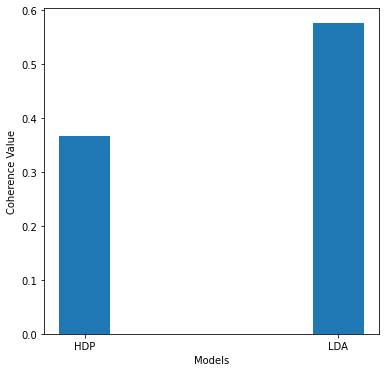

In [38]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(6,6))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

#The coherence score amongst topics is higher for LDA then HDP.
evaluate_bar_graph([hdp_coherence, lda_coherence], ['HDP', 'LDA'])

MODELS

In [39]:
#Splitting the data in train and Test
X_train,X_test,y_train,y_test = train_test_split(df['final cleaned posting text'],df['cluster'], random_state = 23)

#vectorizer
X_train_Tfidf = vectorizer.fit_transform(X_train)
X_test_Tfidf = vectorizer.transform(X_test)

In [40]:
X_test_Tfidf.shape

(365, 13590)

In [41]:
#Defining models

param_grid = {'C': [0.1, 1, 10, 100, 1000],
      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'kernel': ['rbf']}

models = [
    RandomForestClassifier(n_estimators=500, max_depth=8, random_state=23),
    LinearSVC(random_state=23),
    MultinomialNB(),
    LogisticRegression(random_state=23),
    DecisionTreeClassifier(random_state=23),
    GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
]

df_model_accuracy = pd.DataFrame(['RandomForest','LinearSVC','NB','Logit','DecisionTree','GridSearchCV'],columns=['Models'])

In [42]:
df_model_accuracy

,Models
0,RandomForest
1,LinearSVC
2,NB
3,Logit
4,DecisionTree
5,GridSearchCV


In [43]:
model_accuracy = []

for model in models:
  model_name = model_name = model.__class__.__name__
  model.fit(X_train_Tfidf,y_train)
  y_pred = model.predict(X_test_Tfidf)
  accuracy = accuracy_score(y_test, y_pred)
  model_accuracy.append(accuracy)
  
df_model_accuracy['Accuracy'] = model_accuracy

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.256 total time=   2.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.261 total time=   2.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.257 total time=   1.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.251 total time=   1.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [44]:
df_model_accuracy

,Models,Accuracy
0,RandomForest,0.583562
1,LinearSVC,0.887671
2,NB,0.635616
3,Logit,0.827397
4,DecisionTree,0.646575
5,GridSearchCV,0.901370


In [45]:
#Using GridSVC and tuning the hyperparameters
param_grid = {'C': [0.1, 1, 10, 100, 1000],
      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'kernel': ['rbf']}

SVC = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
SVC.fit(X_train_Tfidf,y_train)
y_pred_SVC = SVC.predict(X_test_Tfidf)
accuracy = accuracy_score(y_test, y_pred_SVC)
accuracy

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.256 total time=   2.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.261 total time=   2.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   1.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.251 total time=   2.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.257 total time=   1.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.251 total time=   2.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

0.9013698630136986

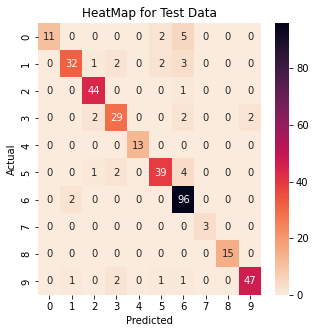

In [46]:
conf_mat = confusion_matrix(y_test, y_pred_SVC)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = sns.cm.rocket_r)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('HeatMap for Test Data')
plt.show()

In [47]:
df.head()

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic
0,prep and event cooks,"[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...,1,4
1,"director, dining services - k12 - pike townshi...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8
2,shop and deliver - no experience required,"[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...,5,5
3,executive chef - k12 - career academy - south ...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8
4,resident district manager - k12 - parkway scho...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8


BERT

In [95]:
!pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

# Subsetting 2 columns for bert analysis
df_bert = df[['final cleaned posting text', 'cluster']]
df_bert.reset_index(inplace=True,drop=True)
df_bert.head()

# Rename columns
df_bert = df_bert.rename(columns = {'final cleaned posting text':'text','cluster':'label'})
df_bert.head()

X_train, X_val, y_train, y_val = train_test_split(df_bert.index.values,
                                                  df_bert.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df_bert.label.values)

df_bert['data_type'] = ['not_set']*df_bert.shape[0]

df_bert.loc[X_train, 'data_type'] = 'train'
df_bert.loc[X_val, 'data_type'] = 'val'

df_bert.groupby(['text', 'label', 'data_type']).count()

#tokenize and encode for bert input
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df_bert[df_bert.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_bert[df_bert.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_bert[df_bert.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_bert[df_bert.data_type=='val'].label.values)

# Split for train,test
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

#define Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

#Define Optimizer
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

#Define Accuracy Metric
label_dict = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j'}
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#Train Model
import random

seed_val = 23
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'/content/drive/My Drive/AUD Project/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

#Predict Results and Get Accuracy
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/My Drive/AUD Project/finetuned_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.1 MB/s 
     |████████████████████████████████| 7.6 MB 53.9 MB/s 
     |████████████████████████████████| 182 kB 56.9 MB/s 


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/414 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.7783263304095338
Validation loss: 1.492373382391995
F1 Score (Weighted): 0.4074581575418313


Epoch 2:   0%|          | 0/414 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.1932588405367257
Validation loss: 1.11994296046969
F1 Score (Weighted): 0.6225167901495084


Epoch 3:   0%|          | 0/414 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8732742484353014
Validation loss: 1.0495869866380954
F1 Score (Weighted): 0.624114054993975


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Accuracy: 0/10

Accuracy: 14/22

Accuracy: 24/29

Accuracy: 10/24

Accuracy: 5/9

Accuracy: 16/30

Accuracy: 46/56

Accuracy: 0/2

Accuracy: 6/7

Accuracy: 21/30



In [48]:
train_vecs = []
for i in range(len(df)):
    top_topics = (
        lda_model_10topics.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(9)]
    train_vecs.append(topic_vec)

In [49]:
index_list = []
for i in train_vecs:
    ind = np.argmax(i)
    index_list.append(ind)

In [50]:
lda_model_10topics

In [51]:
lda_top10_data = lda_model_10topics.print_topics(10, num_words=5)[:10]

In [52]:
overall_topics = []
overall_missed_words = []
for i in range(len(df['final cleaned posting text'])):
    try:
        missing_words = []
        print(df['final cleaned posting text'][i])
        print('The recommended topic is ', lda_model_10topics.print_topics(10, num_words=10)[:10][index_list[i]])
        for j in re.findall(r'"([^"]*)"',lda_top10_data[index_list[i]][1]):
            if j not in list(df['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_topics.append(lda_model_10topics.print_topics(10, num_words=10)[:10][index_list[i]])
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
df['Topics_assigned'] = overall_topics
df['Missing_words'] =  overall_missed_words

Streaming output truncated to the last 5000 lines.
member is not in the review despite being in the top recommended topic, do you want to reconsider?
service is not in the review despite being in the top recommended topic, do you want to reconsider?
customer is not in the review despite being in the top recommended topic, do you want to reconsider?
apply winning family start check great benefit flexible schedule help balance life commitment school childcare family care etc free employee meal limited menu weekly pay anniversary pay paid sick leave hour every hour worked begin accruing upon hire paid family medical leave week year service medicaldental insurance ongoing training build critical skill current future role discount cellphone travel electronics much saving plan company match year service management career advancement opportunity manager promoted hourly position much olive garden family one key success high standard set includes placing health safety team member guest top prio

In [53]:
overall_missed_words = []
for i in range(len(df['final cleaned posting text'])):
    try:
        missing_words = []
        print(df['final cleaned posting text'][i])
        print('The recommended cluster is ',df['cluster'][i], cluster_terms_list[int(df['cluster'][i])])
        for j in cluster_terms_list[int(df['cluster'][i])]:
            if j not in list(df['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
df['Missing_words_cluster'] =  overall_missed_words

Streaming output truncated to the last 5000 lines.
The recommended cluster is  5 ['driver', 'customer', 'work', 'delivery', 'hour', 'job', 'vehicle', 'time', 'day', 'must', 'service', 'shift', 'sale', 'looking', 'pay', 'driving', 'per', 'order', 'experience', 'position']
driver is not in the review despite being in the top recommended topic, do you want to reconsider?
customer is not in the review despite being in the top recommended topic, do you want to reconsider?
delivery is not in the review despite being in the top recommended topic, do you want to reconsider?
job is not in the review despite being in the top recommended topic, do you want to reconsider?
vehicle is not in the review despite being in the top recommended topic, do you want to reconsider?
time is not in the review despite being in the top recommended topic, do you want to reconsider?
day is not in the review despite being in the top recommended topic, do you want to reconsider?
must is not in the review despite bein

In [54]:
df.rename(columns = {'Missing_words':'Missing_words_topic_modelling'}, inplace=True)

In [55]:
df

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic,Topics_assigned,Missing_words_topic_modelling,Missing_words_cluster
0,prep and event cooks,"[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...,1,4,"(4, 0.018*""looking"" + 0.018*""time"" + 0.016*""wo...","[looking, time, work, experience, hour]","[line, line cook, kitchen, food, experience, c..."
1,"director, dining services - k12 - pike townshi...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8,"(8, 0.013*""position"" + 0.012*""food"" + 0.012*""a...",[],"[legendary, roadhouse, texas roadhouse, texas,..."
2,shop and deliver - no experience required,"[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...,5,5,"(5, 0.024*""delivery"" + 0.023*""driver"" + 0.013*...","[sale, area, clean]","[hour, must, shift, sale, pay, per, experience..."
3,executive chef - k12 - career academy - south ...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8,"(8, 0.013*""position"" + 0.012*""food"" + 0.012*""a...",[],"[legendary, roadhouse, texas roadhouse, texas,..."
4,resident district manager - k12 - parkway scho...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8,"(8, 0.013*""position"" + 0.012*""food"" + 0.012*""a...",[],"[legendary, roadhouse, texas roadhouse, texas,..."
...,...,...,...,...,...,...,...,...
1459,steward | biân chicago - food & beverage | now...,"[culinary, agent, working, team, biân, chicago...",culinary agent working team biân chicago food ...,3,7,"(7, 0.030*""restaurant"" + 0.019*""apply"" + 0.013...","[restaurant, boca, hospitality]",[]
1460,sweet diner-- full time foh positions,"[position, available, front, house, host, tip,...",position available front house host tip expedi...,6,4,"(4, 0.018*""looking"" + 0.018*""time"" + 0.016*""wo...","[time, hour]","[line cook, prep, must, experienced, position,..."
1461,line and prep cooks needed,"[come, work, one, best, mexican, restaurant, n...",come work one best mexican restaurant northwes...,6,4,"(4, 0.018*""looking"" + 0.018*""time"" + 0.016*""wo...","[looking, time, experience, hour]","[event, experience, manager, restaurant, time,..."
1462,chef/kitchen lead/ line cooks immediate opening,"[immediate, opening, kitchen, staff, kitchen, ...",immediate opening kitchen staff kitchen lead p...,1,4,"(4, 0.018*""looking"" + 0.018*""time"" + 0.016*""wo...","[time, hour]","[line cook, prep, must, restaurant, experience..."


In [56]:
df['Missing_words_both'] = [set(a) & set(b) for a,b in zip(df['Missing_words_topic_modelling'],df['Missing_words_cluster'])]

In [57]:
df.head()

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic,Topics_assigned,Missing_words_topic_modelling,Missing_words_cluster,Missing_words_both
0,prep and event cooks,"[need, experienced, prep, cook, need, cook, af...",need experienced prep cook need cook afternoon...,1,4,"(4, 0.018*""looking"" + 0.018*""time"" + 0.016*""wo...","[looking, time, work, experience, hour]","[line, line cook, kitchen, food, experience, c...","{work, experience, looking}"
1,"director, dining services - k12 - pike townshi...","[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8,"(8, 0.013*""position"" + 0.012*""food"" + 0.012*""a...",[],"[legendary, roadhouse, texas roadhouse, texas,...",{}
2,shop and deliver - no experience required,"[shop, deliver, flexible, schedule, earn, addi...",shop deliver flexible schedule earn additional...,5,5,"(5, 0.024*""delivery"" + 0.023*""driver"" + 0.013*...","[sale, area, clean]","[hour, must, shift, sale, pay, per, experience...",{sale}
3,executive chef - k12 - career academy - south ...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8,"(8, 0.013*""position"" + 0.012*""food"" + 0.012*""a...",[],"[legendary, roadhouse, texas roadhouse, texas,...",{}
4,resident district manager - k12 - parkway scho...,"[salary, chartwells, goal, make, sure, student...",salary chartwells goal make sure student leave...,4,8,"(8, 0.013*""position"" + 0.012*""food"" + 0.012*""a...",[],"[legendary, roadhouse, texas roadhouse, texas,...",{}


END!